In [1]:
# setting up env
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_binary_pairs(num_samples, num_digits):
    """
    Generates pairs of binary numbers and their XOR result.
    
    Parameters:
    - num_samples: Number of samples to generate.
    - num_digits: Number of digits in each binary number.
    
    Returns:
    - A tuple containing input pairs and their XOR results.
    """
    # Generate random binary numbers
    binary_numbers = torch.randint(0, 2, (num_samples, 2, num_digits))
    
    # Calculate XOR
    xor_results = torch.logical_xor(binary_numbers[:, 0, :], binary_numbers[:, 1, :]).float()
    
    # Prepare inputs by reshaping and converting to float for neural network compatibility
    inputs = binary_numbers.view(num_samples, -1).float()
    
    return inputs, xor_results

In [3]:
def split_data(inputs, targets, train_ratio=0.8):
    """
    Splits the dataset into training and test sets.
    
    Parameters:
    - inputs: Input data.
    - targets: Target data.
    - train_ratio: Ratio of the dataset to be used as training data.
    
    Returns:
    - Training and test sets.
    """
    num_samples = inputs.size(0)
    indices = torch.randperm(num_samples)
    split = int(np.floor(train_ratio * num_samples))
    
    train_indices, test_indices = indices[:split], indices[split:]
    
    X_train, X_test = inputs[train_indices], inputs[test_indices]
    y_train, y_test = targets[train_indices], targets[test_indices]
    
    return X_train, X_test, y_train, y_test

In [4]:
# Define the MLP model
class BinaryOpMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryOpMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x


In [ ]:
class BinaryOpMLPDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(BinaryOpMLPDropout, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer2(x))
        return x

# Model 1
 - 1000 datapoints
 - Xor Binary numbers
 - 1 hidden layer, 10 wide
 - No regularisation

In [5]:
# Example usage
num_samples = 1000  # Total number of samples 100=overfitting, 10000=generalisation
num_digits = 4  # Number of digits in each binary number

# Generate data
inputs, xor_results = generate_binary_pairs(num_samples, num_digits)

# Split data
X_train, X_test, y_train, y_test = split_data(inputs, xor_results, train_ratio=0.8)

# Showing the shapes of the datasets
print("Training input shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test target shape:", y_test.shape)
# Example parameters
input_size = num_digits * 2  # For 4-digit binary numbers, 8 inputs total
hidden_size = 5  # Example hidden layer size
output_size = num_digits  # For 4-digit binary output

# Create the model
model = BinaryOpMLP(input_size, hidden_size, output_size)

Training input shape: torch.Size([800, 8])
Training target shape: torch.Size([800, 4])
Test input shape: torch.Size([200, 8])
Test target shape: torch.Size([200, 4])


In [6]:
# Loss and optimizer
criterion = nn.BCELoss()  # Since we're outputting probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
epochs = 10_000
training_losses = []
test_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()  # Ensure the model is in training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    training_losses.append(loss.item())
    
    # Calculate test loss
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Ensure gradients are not calculated for the test data
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 1000, Training Loss: 0.49516716599464417, Test Loss: 0.49554675817489624
Epoch 2000, Training Loss: 0.3913153409957886, Test Loss: 0.3923787772655487
Epoch 3000, Training Loss: 0.3695576786994934, Test Loss: 0.37231341004371643
Epoch 4000, Training Loss: 0.359862357378006, Test Loss: 0.3659720718860626
Epoch 5000, Training Loss: 0.35074383020401, Test Loss: 0.36259976029396057
Epoch 6000, Training Loss: 0.34309008717536926, Test Loss: 0.35970717668533325
Epoch 7000, Training Loss: 0.33423832058906555, Test Loss: 0.3555353879928589
Epoch 8000, Training Loss: 0.31527820229530334, Test Loss: 0.3347654342651367
Epoch 9000, Training Loss: 0.3043074905872345, Test Loss: 0.31725451350212097
Epoch 10000, Training Loss: 0.29692089557647705, Test Loss: 0.3081888258457184


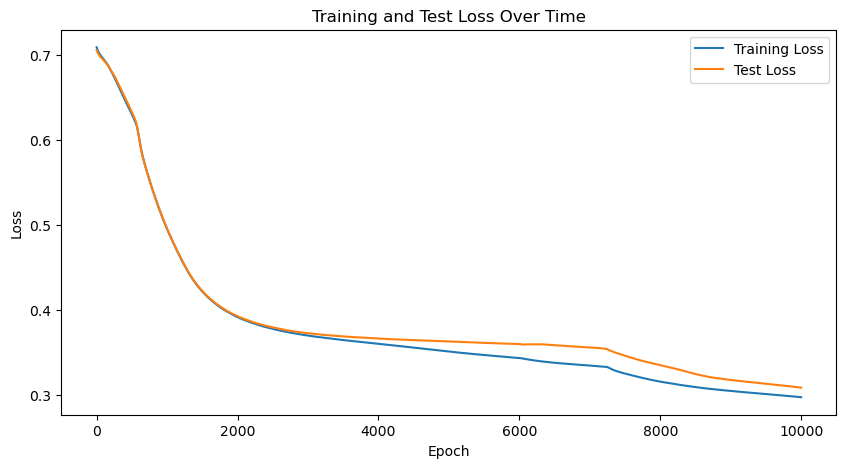

In [7]:
# Plotting both training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

In [8]:

model.eval()
with torch.inference_mode():
    outputs = model(X_test[:3])

outputs = (outputs > 0.5).to(dtype=torch.float32)

for i in range(3):
    print(f"Input: {X_test[i][:2]} XOR {X_test[i][2:]}, Prediction: {outputs[i]}, Actual: {y_test[i]}")

Input: tensor([0., 0.]) XOR tensor([0., 0., 0., 0., 0., 0.]), Prediction: tensor([0., 0., 0., 0.]), Actual: tensor([0., 0., 0., 0.])
Input: tensor([1., 1.]) XOR tensor([0., 0., 1., 0., 0., 0.]), Prediction: tensor([1., 1., 0., 0.]), Actual: tensor([0., 1., 0., 0.])
Input: tensor([1., 0.]) XOR tensor([1., 1., 1., 1., 1., 0.]), Prediction: tensor([1., 1., 0., 1.]), Actual: tensor([0., 1., 0., 1.])


In [9]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-2.3337e-02, -3.6138e-02, -2.5934e+00, -6.3328e+00, -1.5141e-02,
                       -2.9702e-02,  2.5798e+00, -6.3476e+00],
                      [-1.8142e+00, -4.0408e+00, -1.5221e-02,  1.8792e-03, -1.7907e+00,
                       -4.0408e+00,  5.7566e-02,  1.4421e-03],
                      [-5.0598e-04,  7.5176e-02, -3.9795e+00,  7.6646e-02, -6.3517e-04,
                        7.1154e-02,  3.9799e+00,  7.5735e-02],
                      [-4.7286e+00, -2.0748e+00,  1.9423e-02,  1.8209e-02, -4.7286e+00,
                       -2.2227e+00, -3.7266e-03,  3.4793e-03],
                      [-3.7697e-02, -5.9517e-02, -2.9067e+00,  2.6129e+00, -2.8883e-02,
                       -5.8811e-02,  2.9043e+00,  2.6159e+00]])),
             ('layer1.bias',
              tensor([ 3.7680,  3.9814, -0.2226,  4.6909, -0.8652])),
             ('layer2.weight',
              tensor([[ 0.0556,  1.1292, -0.0544, -6.6139,  0.0700],
            

# Model 2
 - 100 datapoints
 - Xor Binary numbers
 - 1 hidden layer, 10 wide
 - No regularisation

In [76]:
# Example usage
num_samples = 100  # Total number of samples 100=overfitting, 10000=generalisation
num_digits = 4  # Number of digits in each binary number

# Generate data
inputs, xor_results = generate_binary_pairs(num_samples, num_digits)

# Split data
X_train, X_test, y_train, y_test = split_data(inputs, xor_results, train_ratio=0.8)

# Showing the shapes of the datasets
print("Training input shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test target shape:", y_test.shape)
# Example parameters
input_size = num_digits * 2  # For 4-digit binary numbers, 8 inputs total
hidden_size = 5  # Example hidden layer size
output_size = num_digits  # For 4-digit binary output

# Create the model
model = BinaryOpMLP(input_size, hidden_size, output_size)

Training input shape: torch.Size([80, 8])
Training target shape: torch.Size([80, 4])
Test input shape: torch.Size([20, 8])
Test target shape: torch.Size([20, 4])


In [77]:
# Loss and optimizer
criterion = nn.BCELoss()  # Since we're outputting probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
epochs = 20_000
training_losses = []
test_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()  # Ensure the model is in training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    training_losses.append(loss.item())
    
    # Calculate test loss
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Ensure gradients are not calculated for the test data
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 1000, Training Loss: 0.47757488489151, Test Loss: 0.5688716769218445
Epoch 2000, Training Loss: 0.3594518303871155, Test Loss: 0.4684901237487793
Epoch 3000, Training Loss: 0.3119940459728241, Test Loss: 0.4169181287288666
Epoch 4000, Training Loss: 0.29254740476608276, Test Loss: 0.40292906761169434
Epoch 5000, Training Loss: 0.280265748500824, Test Loss: 0.4019348621368408
Epoch 6000, Training Loss: 0.2705414891242981, Test Loss: 0.40074577927589417
Epoch 7000, Training Loss: 0.2619955837726593, Test Loss: 0.4154340624809265
Epoch 8000, Training Loss: 0.25535061955451965, Test Loss: 0.4379677176475525
Epoch 9000, Training Loss: 0.2488698959350586, Test Loss: 0.4813867509365082
Epoch 10000, Training Loss: 0.24304230511188507, Test Loss: 0.5643006563186646
Epoch 11000, Training Loss: 0.23867562413215637, Test Loss: 0.643865704536438
Epoch 12000, Training Loss: 0.2353793829679489, Test Loss: 0.733373761177063
Epoch 13000, Training Loss: 0.23277339339256287, Test Loss: 0.8446178436

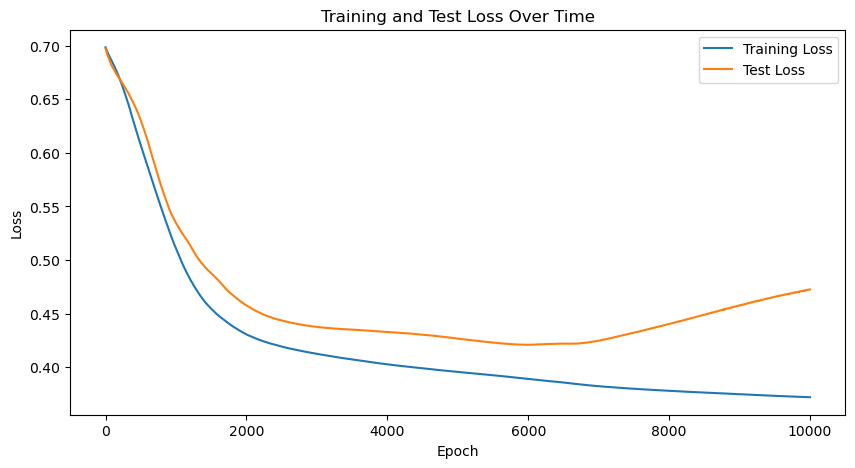

In [12]:
# Plotting both training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

In [ ]:
# Model 3
 - 50 datapoints
 - Xor Binary numbers
 - 1 hidden layer, 100 wide
 - OVERFITTER

In [73]:
# Example usage
num_samples = 50  # Total number of samples 100=overfitting, 10000=generalisation
num_digits = 4  # Number of digits in each binary number

# Generate data
inputs, xor_results = generate_binary_pairs(num_samples, num_digits)

# Split data
X_train, X_test, y_train, y_test = split_data(inputs, xor_results, train_ratio=0.8)

# Showing the shapes of the datasets
print("Training input shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test target shape:", y_test.shape)
# Example parameters
input_size = num_digits * 2  # For 4-digit binary numbers, 8 inputs total
hidden_size = 100  # Example hidden layer size
output_size = num_digits  # For 4-digit binary output

# Create the model
model = BinaryOpMLP(input_size, hidden_size, output_size)

Training input shape: torch.Size([40, 8])
Training target shape: torch.Size([40, 4])
Test input shape: torch.Size([10, 8])
Test target shape: torch.Size([10, 4])


In [74]:
# Loss and optimizer
criterion = nn.BCELoss()  # Since we're outputting probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
epochs = 10_000
training_losses = []
test_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()  # Ensure the model is in training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    training_losses.append(loss.item())
    
    # Calculate test loss
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Ensure gradients are not calculated for the test data
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 10000 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 10000, Training Loss: 8.94681488716742e-06, Test Loss: 1.1044244766235352


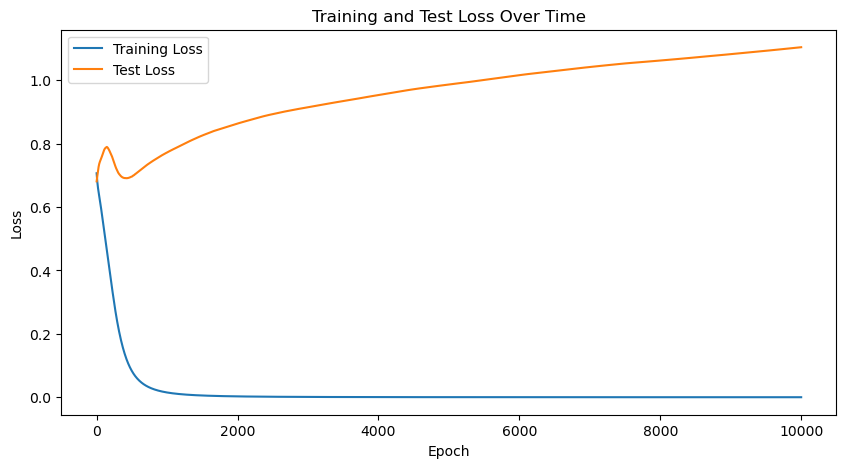

In [75]:
# Plotting both training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

# Model 4
 - 100 datapoints
 - Xor Binary numbers
 - 1 hidden layer, 10 wide
 - Weight decay regularisation

In [64]:
# Example usage
num_samples = 50  # Total number of samples 100=overfitting, 10000=generalisation
num_digits = 4  # Number of digits in each binary number

# Generate data
inputs, xor_results = generate_binary_pairs(num_samples, num_digits)

# Split data
X_train, X_test, y_train, y_test = split_data(inputs, xor_results, train_ratio=0.8)

# Showing the shapes of the datasets
print("Training input shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test target shape:", y_test.shape)
# Example parameters
input_size = num_digits * 2  # For 4-digit binary numbers, 8 inputs total
hidden_size = 100  # Example hidden layer size
output_size = num_digits  # For 4-digit binary output

# Create the model
model = BinaryOpMLP(input_size, hidden_size, output_size)

Training input shape: torch.Size([40, 8])
Training target shape: torch.Size([40, 4])
Test input shape: torch.Size([10, 8])
Test target shape: torch.Size([10, 4])


In [65]:
# Loss and optimizer
criterion = nn.BCELoss()  # Since we're outputting probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-3)


# Training the model
epochs = 20_000
training_losses = []
test_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()  # Ensure the model is in training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    training_losses.append(loss.item())
    
    # Calculate test loss
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Ensure gradients are not calculated for the test data
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 10000 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 10000, Training Loss: 0.024305183440446854, Test Loss: 0.07447464764118195
Epoch 20000, Training Loss: 0.024298550561070442, Test Loss: 0.07301852852106094


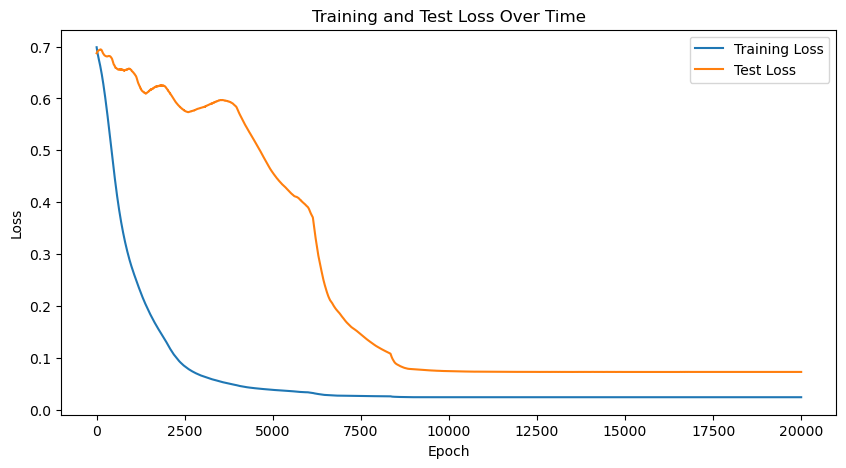

In [66]:
# Plotting both training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

# Model 5
 - 100 datapoints
 - Xor Binary numbers
 - 1 hidden layer, 10 wide
 - Weight decay regularisation
 - Train for ages mate

In [94]:
# Example usage
num_samples = 30  # Total number of samples 100=overfitting, 10000=generalisation
num_digits = 4  # Number of digits in each binary number

# Generate data
inputs, xor_results = generate_binary_pairs(num_samples, num_digits)

# Split data
X_train, X_test, y_train, y_test = split_data(inputs, xor_results, train_ratio=0.8)

# Showing the shapes of the datasets
print("Training input shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test target shape:", y_test.shape)
# Example parameters
input_size = num_digits * 2  # For 4-digit binary numbers, 8 inputs total
hidden_size = 250  # Example hidden layer size
output_size = num_digits  # For 4-digit binary output

# Create the model
model = BinaryOpMLP(input_size, hidden_size, output_size)

Training input shape: torch.Size([24, 8])
Training target shape: torch.Size([24, 4])
Test input shape: torch.Size([6, 8])
Test target shape: torch.Size([6, 4])


In [95]:
# Loss and optimizer
criterion = nn.BCELoss()  # Since we're outputting probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)


# Training the model
epochs = 100_000
training_losses = []
test_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()  # Ensure the model is in training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    training_losses.append(loss.item())
    
    # Calculate test loss
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Ensure gradients are not calculated for the test data
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 10000 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

Epoch 10000, Training Loss: 0.00022978930792305619, Test Loss: 0.24811013042926788
Epoch 20000, Training Loss: 0.00022622320102527738, Test Loss: 0.23274950683116913
Epoch 30000, Training Loss: 0.00022619649826083332, Test Loss: 0.2343633770942688
Epoch 40000, Training Loss: 0.00022621203970629722, Test Loss: 0.23425643146038055
Epoch 50000, Training Loss: 0.00022619189985562116, Test Loss: 0.2345861792564392
Epoch 60000, Training Loss: 0.00022614095360040665, Test Loss: 0.23470930755138397
Epoch 70000, Training Loss: 0.0002261853514937684, Test Loss: 0.23425184190273285
Epoch 80000, Training Loss: 0.00022617973445449024, Test Loss: 0.23453474044799805
Epoch 90000, Training Loss: 0.00022615633497480303, Test Loss: 0.23443235456943512
Epoch 100000, Training Loss: 0.00022617327340412885, Test Loss: 0.23426282405853271


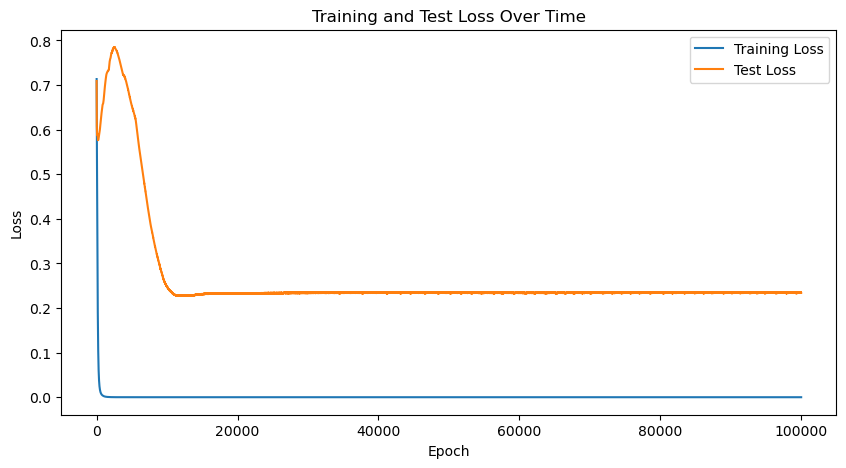

In [96]:
# Plotting both training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()